# Quantum consensus network (QCN) local simulator
#### Peter Rohde (BTQ)

## Code

### Dependencies

In [1]:
using Term
using Random
using Statistics
using StatsBase
using LaTeXStrings
using Plots; gr()
using PlotThemes
using Plots.PlotMeasures

import Base: show

theme(:default)

### Data structures

In [2]:
mutable struct EstablishedBitstring
    node_src::Int64 # Node ID of source party
    node_dst::Int64 # Node ID of destination party
    bitstring::BitVector # QRNG bitstring
end

mutable struct Node
    id::Int64 # Node ID (maps to public key)
    received_requests::Vector{Int64} # Node IDs of incoming QRNG protocol requests
    bitstrings::Vector{EstablishedBitstring} # Established QRNG bitstrings with other nodes
    p_node::Float64 # Probability of node participation in protocol round (vertex percolations)
    p_comms::Float64 # Probability that a communications link is operational (edge percolations)

    function Node(id::Int64, p_node::Float64=1.0, p_comms::Float64=1.0)
        new(id, [], [], p_node, p_comms)
    end
end

mutable struct Network
    nodes::Vector{Node} # Network nodes
    commits::Vector{EstablishedBitstring} # QRNG bitstrings commited to network by nodes
    num_bits::Int64 # QRN bit-length

    function Network(num_nodes::Int64, p_node::Float64=1.0, p_comms::Float64=1.0)
        nodes = [Node(i, p_node, p_comms) for i in 1:num_nodes]
        commits = Vector{EstablishedBitstring}()
        num_bits = 10
        new(nodes, commits, num_bits)
    end
end
;

### Functions

In [3]:
function show(io::IO, network::Network)
    println(io, "Network summary:")
    println(io, "\tNetwork nodes: ", length(network.nodes))
    for node in network.nodes
        println(io, "\t\t", node)
    end
    println(io, "\tCommitted bitstrings: ", length(network.commits))
    for commit in network.commits
        println(io, "\t\t($(commit.node_src) -> $(commit.node_dst)): $(commit.bitstring)")
    end
end

# Return `true` with probability `p` otherwise `false`
function rand_bool(p::Float64)::Bool
    return rand() < p
end

# Get all unique pairs of `nodes` (order independent)
function get_node_pairs(nodes::Vector{Int64})
    node_pairs = Vector{Tuple{Int64,Int64}}() # All unique node pairs
    for i in 1:length(nodes)
        for j in (i+1):length(nodes)
            node_pair = (nodes[i], nodes[j])
            push!(node_pairs, node_pair)
        end
    end
    return node_pairs
end

# Get all unique pairs of `nodes` (order independent)
function get_node_pairs(nodes::Vector{Node})
    return get_node_pairs(map(x -> x.id, nodes))
end

# Send a request to execute two-party QRNG from `node_src` to `node_dst`
function issue_QRNG_request!(node_src::Int64, node_dst::Int64, network::Network)
    push!(network.nodes[node_dst].received_requests, node_src)
end

# `node` initiates two-party QRNG requests to all other nodes
function issue_QRNG_requests!(node::Int64, network::Network)
    if rand_bool(network.nodes[node].p_node) # Participate with probability `p_node`
        for target in 1:length(network.nodes)
            if node != target
                issue_QRNG_request!(node, target, network)
            end
        end
    end
end

# `node_src` commits `bitstring` established with `node_dst` to the `network`
function commit_bitstring!(node_src::Int64, node_dst::Int64, bitstring::BitVector, network::Network)
    if rand_bool(network.nodes[node_src].p_comms)
        # Valid commit with probability `p_comms`
        valid_commit = EstablishedBitstring(node_src, node_dst, bitstring)
        push!(network.commits, valid_commit)
    else
        # Otherwise invalid commit
        invalid_commit = EstablishedBitstring(node_src, node_dst, BitVector([false]))
        push!(network.commits, invalid_commit)
    end
end

# Execute pairwise QRNG protocol between `nodeA` and `nodeB`
function execute_QRNG_pair!(nodeA::Int64, nodeB::Int64, network::Network)
    AinB = network.nodes[nodeA].id in network.nodes[nodeB].received_requests
    BinA = network.nodes[nodeB].id in network.nodes[nodeA].received_requests
    connected = AinB && AinB
    if connected
        established_bitstring = bitrand(network.num_bits)
        commit_bitstring!(nodeA, nodeB, established_bitstring, network)
        commit_bitstring!(nodeB, nodeA, established_bitstring, network)
    end
end

# Execute dQRNG protocol for entire `network`
function execute_protocol!(network::Network)
    # Nodes issue two-party QRNG protocol requests with all other nodes
    for node in 1:length(network.nodes)
        issue_QRNG_requests!(node, network)
    end

    # Execute all pairwise QRNG protocols
    node_pairs = get_node_pairs(network.nodes)
    for node_pair in node_pairs
        execute_QRNG_pair!(node_pair[1], node_pair[2], network)
    end
end

# Get the `compliance_matrix` for the `network` 
function get_compliance_matrix(network::Network)::Matrix{Bool}
    compliance_matrix = fill(false, length(network.nodes), length(network.nodes))

    for node_src in 1:length(network.nodes)
        for node_dst in 1:length(network.nodes)
            if node_src != node_dst
                commit_src_idx = findfirst(x -> x.node_src == node_src && x.node_dst == node_dst, network.commits)
                commit_dst_idx = findfirst(x -> x.node_src == node_dst && x.node_dst == node_src, network.commits)
                commit_src = commit_src_idx === nothing ? nothing : network.commits[commit_src_idx]
                commit_dst = commit_dst_idx === nothing ? nothing : network.commits[commit_dst_idx]
                if commit_src != nothing && commit_dst != nothing
                    if commit_src.bitstring == commit_dst.bitstring && length(commit_src.bitstring) > 1 && length(commit_dst.bitstring) > 1
                        compliance_matrix[node_src, node_dst] = true
                    end
                end
            else
                compliance_matrix[node_src, node_dst] = true
            end
        end
    end

    return compliance_matrix
end

# Reduce `compliance_matrix` to `unanimous_subset` (fully connected subgraph representing unanimous-majority)
function reduce_compliance_matrix(compliance_matrix::Matrix{Bool}, network::Network)::Vector{Int64}
    min_majority::Int64 = floor(length(network.nodes) / 2) + 1

    # Majority subset
    nodes_with_majority = Vector{Int64}()
    for node in 1:length(network.nodes)
        if sum(compliance_matrix[node, :]) >= min_majority
            push!(nodes_with_majority, node)
        end
    end

    # Unanimous subset
    unanimous_subset = Vector{Int64}()
    for node in nodes_with_majority
        unanimous = true
        for other_node in nodes_with_majority
            if !compliance_matrix[node, other_node]
                unanimous = false
            end
        end
        if unanimous
            push!(unanimous_subset, node)
        end
    end

    return unanimous_subset
end

# Evaluate the consensus dQRNG bitstring associated with a `unanimous_subset`
function evaluate_consensus_bitstring(unanimous_subset::Vector{Int64}, network::Network)::BitVector
    min_majority::Int64 = floor(length(network.nodes) / 2) + 1
    if length(unanimous_subset) < min_majority
        return BitVector([false])
    end

    compliant_node_pairs = get_node_pairs(unanimous_subset)
    compliant_bitstrings = Vector{BitVector}()

    for node_pair in compliant_node_pairs
        commit_idx = findfirst(x -> x.node_src == node_pair[1] && x.node_dst == node_pair[2], network.commits)
        commit = commit_idx === nothing ? nothing : network.commits[commit_idx]
        if length(commit.bitstring) > 0
            push!(compliant_bitstrings, commit.bitstring)
        end
    end
    if length(compliant_bitstrings) > 0
        consensus_bitstring = reduce((x, y) -> xor.(x, y), compliant_bitstrings)
    else
        consensus_bitstring = BitVector([false])
    end

    return consensus_bitstring
end

# Observe the `network` and determine the `consensus_bitstring` and `unanimous_subset`
function consensus_outcome(network::Network)
    compliance_matrix = get_compliance_matrix(network)
    unanimous_subset = reduce_compliance_matrix(compliance_matrix, network)
    consensus_bitstring = evaluate_consensus_bitstring(unanimous_subset, network)
    return (consensus_bitstring, unanimous_subset)
end

# Perform Monte-Carlo simulation
function monte_carlo_stats(num_nodes::Int64, p_node::Float64, p_comms::Float64, iters::Int64)
    consensus_set_size = Vector{Float64}()
    consensus_count::Float64 = 0.0
    min_majority::Int64 = floor(num_nodes/2) + 1

    for i in 1:iters
        network = Network(num_nodes, p_node, p_comms)
        for node in network.nodes
            node.p_node = p_node
        end
        execute_protocol!(network)
        (consensus_bitstring, unanimous_subset) = consensus_outcome(network)
        push!(consensus_set_size, length(unanimous_subset))
        if length(unanimous_subset) >= min_majority
            consensus_count += 1
        end
    end
    consensus_set_size_mu::Float64 = isempty(consensus_set_size) ? 0 : mean(consensus_set_size)
    consensus_success_prob::Float64 = consensus_count/iters

    return (consensus_set_size_mu, consensus_success_prob)
end
;

## Results
+ $n_\mathrm{nodes}$ = number of network nodes.
+ $p_\mathrm{node}$ = probability of node participating in protocol (equivalent to graph vertex percolations).
+ $p_\mathrm{comms}$ = probability of communication link failure (equivalent to graph edge percolations).
+ $\mu_\mathrm{size}$ = average number of independent QRNG bitstrings contributing to consensus.
+ $p_\mathrm{success}$ = probability of forming consensus (majority of nodes are compliant).

### 2D Plots

#### Calculations

In [4]:
num_nodes = 30 # Number of nodes
iters = 10000 # Monte-Carlo iterations

p_node_min = 0.0
p_node_step = 0.025
p_node_max = 1.0

p_comms_min = 0.9
p_comms_step = 0.005
p_comms_max = 1.0

p_node_range = collect(p_node_min:p_node_step:p_node_max)
p_comms_range = collect(p_comms_min:p_comms_step:p_comms_max)

results_node = monte_carlo_stats.(num_nodes, p_node_range, 1.0, iters)
results_mu_node = map(x -> x[1], results_node)
results_p_node = map(x -> x[2], results_node)

results_comms = monte_carlo_stats.(num_nodes, 1.0, p_comms_range, iters)
results_mu_comms = map(x -> x[1], results_comms)
results_p_comms = map(x -> x[2], results_comms)
;

#### Plots

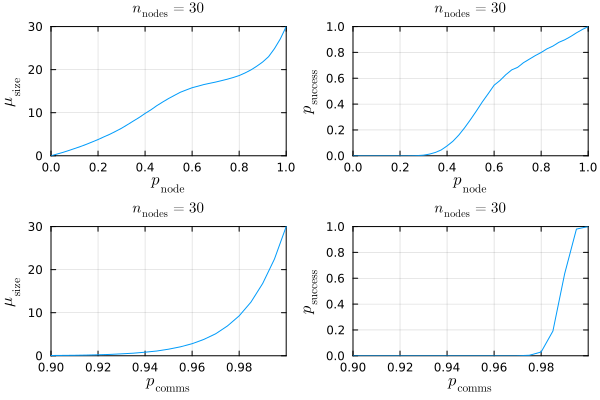

In [11]:
plot_title = "\$n_\\mathrm{nodes}=$num_nodes\$"
axis_label_p_node = L"p_\mathrm{node}"
axis_label_p_comms = L"p_\mathrm{comms}"
axis_label_mu_size = L"\mu_\mathrm{size}"
axis_label_p_success = L"p_\mathrm{success}"

fig_mu_node = plot(p_node_range, results_mu_node, xlims=(p_node_min,p_node_max), ylims=(0,num_nodes), xlabel=axis_label_p_node, ylabel=axis_label_mu_size, label=:none, framestyle = :box)
fig_p_node = plot(p_node_range, results_p_node, xlims=(p_node_min,p_node_max), ylims=(0,1), xlabel=axis_label_p_node, ylabel=axis_label_p_success, label=:none, framestyle=:box)
    
fig_mu_comms = plot(p_comms_range, results_mu_comms, xlims=(p_comms_min,p_comms_max), ylims=(0,num_nodes), xlabel=axis_label_p_comms, ylabel=axis_label_mu_size, label=:none, framestyle=:box)
fig_p_comms = plot(p_comms_range, results_p_comms, xlims=(p_comms_min,p_comms_max), ylims=(0,1), xlabel=axis_label_p_comms, ylabel=axis_label_p_success, label=:none, framestyle=:box)

plot_comb_2d = plot(fig_mu_node, fig_p_node, fig_mu_comms, fig_p_comms, layout=(2,2), size=(600,400), title=plot_title, titlefontsize=10)

savefig(plot_comb_2d, "fig_out.svg")
savefig(plot_comb_2d, "fig_out.pdf")
savefig(plot_comb_2d, "fig_out.png")

plot_comb_2d

### 3D Plots

#### Calculations

In [7]:
iters = 100 # Monte-Carlo iterations

p_node_min = 0.0
p_node_step = 0.05
p_node_max = 1.0

p_comms_min = 0.9
p_comms_step = 0.005
p_comms_max = 1.0

n_nodes_min = 0
n_nodes_step = 5
n_nodes_max = 30

p_node_range = collect(p_node_min:p_node_step:p_node_max)
p_comms_range = collect(p_comms_min:p_comms_step:p_comms_max)
n_nodes_range = collect(n_nodes_min:n_nodes_step:n_nodes_max)

results_3d_node = monte_carlo_stats.(n_nodes_range, p_node_range', 1.0, iters)
results_3d_mu_node = map(x -> x[1], results_3d_node)
results_3d_p_node = map(x -> x[2], results_3d_node)

results_3d_comms = monte_carlo_stats.(n_nodes_range, 1.0, p_comms_range', iters)
results_3d_mu_comms = map(x -> x[1], results_3d_comms)
results_3d_p_comms = map(x -> x[2], results_3d_comms)
;

#### Plots

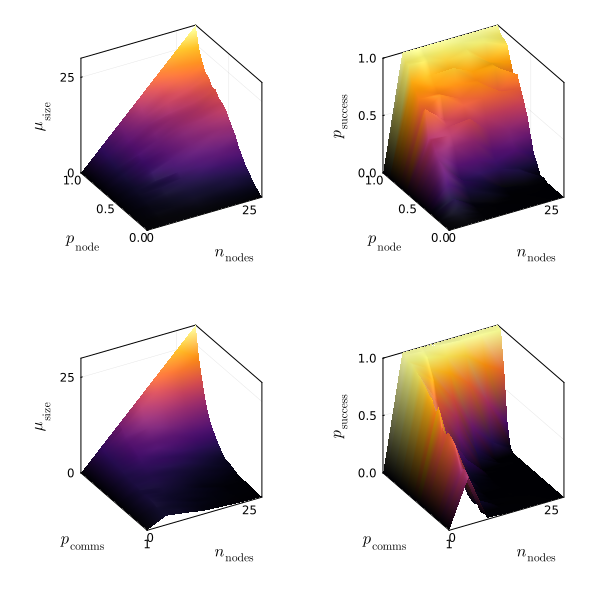

In [8]:
using Plots; gr()

camera_angle = (60,30)

xlabel_p_node = L"p_\mathrm{node}"
xlabel_p_comms = L"p_\mathrm{comms}"
ylabel_n_nodes = L"n_\mathrm{nodes}"
zlabel_p_success = L"p_\mathrm{success}"
zlabel_p_mu_size = L"\mu_\mathrm{size}"

xticks_p = [0, 0.5, 1]
yticks_n = collect(0:25:num_nodes)
zticks_n = collect(0:25:num_nodes)
zticks_p = [0, 0.5, 1]

# Against p_node
fig_3d_mu_node = surface(p_node_range, n_nodes_range', results_3d_mu_node,
xlabel = xlabel_p_node, ylabel = ylabel_n_nodes, zlabel = zlabel_p_mu_size,
    xticks = xticks_p, yticks = yticks_n, zticks = zticks_n,
    xflip = true, legend=:none, camera=camera_angle, framestyle=:box)
fig_3d_p_node = surface(p_node_range, n_nodes_range', results_3d_p_node,
    xlabel = xlabel_p_node, ylabel = ylabel_n_nodes, zlabel = zlabel_p_success,
    xticks = xticks_p, yticks = yticks_n, zticks = zticks_p,
    xflip = true, legend=:none, camera=camera_angle, framestyle=:box)

# Against p_comms
fig_3d_mu_comms = surface(p_comms_range, n_nodes_range', results_3d_mu_comms, 
    xlabel = xlabel_p_comms, ylabel = ylabel_n_nodes, zlabel = zlabel_p_mu_size,
    xticks = xticks_p, yticks = yticks_n, zticks = zticks_n,
    xflip = true, legend=:none, camera=camera_angle, framestyle=:box)
fig_3d_p_comms = surface(p_comms_range, n_nodes_range', results_3d_p_comms, 
    xlabel = xlabel_p_comms, ylabel = ylabel_n_nodes, zlabel = zlabel_p_success, 
    xticks = xticks_p, yticks = yticks_n, zticks = zticks_p,
    xflip = true, legend=:none, camera=camera_angle, framestyle=:box)

plot_comb_3d = plot(fig_3d_mu_node, fig_3d_p_node, fig_3d_mu_comms, fig_3d_p_comms,
    layout = (2,2), size = (600,600))

### Playground

In [145]:
using CairoMakie
CairoMakie.surface(results_3d_mu_node, axis=(type=Axis3, xlabelrotation=0, ylabelrotation=0, zlabelrotation=0))
CairoMakie.contour3d!(results_3d_mu_node)

Plot{Makie.contour3d, Tuple{StepRangeLen{Float32, Float64, Float64, Int64}, StepRangeLen{Float32, Float64, Float64, Int64}, Matrix{Float32}}}

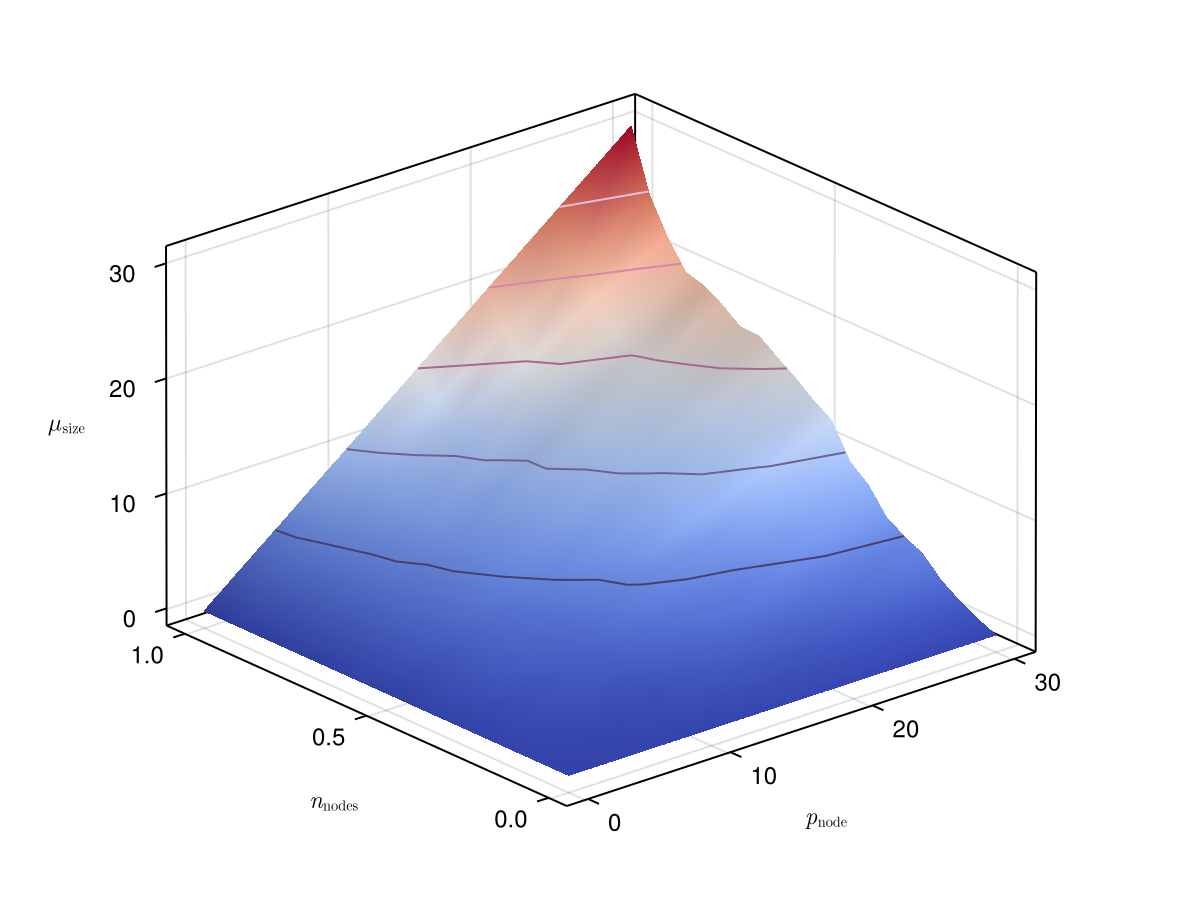

In [236]:
fig = CairoMakie.Figure(fontsize=12)
CairoMakie.Axis3(fig[1,1], 
    xlabel=xlabel_p_node, ylabel=ylabel_n_nodes, zlabel=zlabel_p_mu_size,
    xlabelrotation=0, ylabelrotation=0, zlabelrotation=0)
CairoMakie.surface!(n_nodes_range, p_node_range, results_3d_mu_node, colormap=:coolwarm)
# CairoMakie.wireframe!(n_nodes_range, p_node_range, results_3d_mu_node, alpha=0.1)
CairoMakie.contour3d!(n_nodes_range, p_node_range, results_3d_mu_node, colormap=:acton)
fig

# fig_3d_mu_node = surface(p_node_range, n_nodes_range', results_3d_mu_node,
# xlabel = xlabel_p_node, ylabel = ylabel_n_nodes, zlabel = zlabel_p_mu_size,
# xticks = xticks_p, yticks = yticks_n, zticks = zticks_n,
# xflip = true, legend=:none, camera=camera_angle, framestyle=:box)

In [ ]:
CairoMakie.plot(p_node_range, results_mu_node, 
    xlims=(p_node_min,p_node_max), ylims=(0,num_nodes), 
    xlabel=axis_label_p_node, ylabel=axis_label_mu_size,
    label=:none, framestyle = :box)